In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import braingeneers
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
import scipy.io as sio
import scipy
from scipy.ndimage import gaussian_filter1d
import glob
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import random

In [2]:
sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_5_curated.zip')

In [3]:
def plot_raster(sd):
    idces, times = sd.idces_times()
    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()
    
def raster_analysis(sd, seconds=20):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)# in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float),sigma=sigma) 
    t = np.linspace(0,sd.length,pop_rate.shape[0])/1000

    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax2 = ax.twinx()
    ax2.plot(t,pop_rate_smooth,c='r')

    ax.set_xlim(0,seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    plt.show()

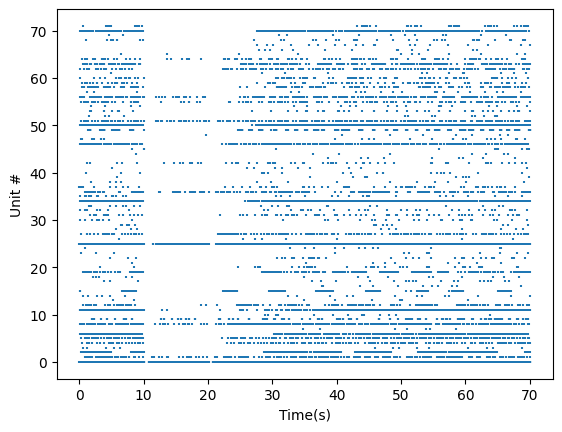

In [4]:
plot_raster(sd)

In [5]:
sd_start = sd.subtime(0, 10000)

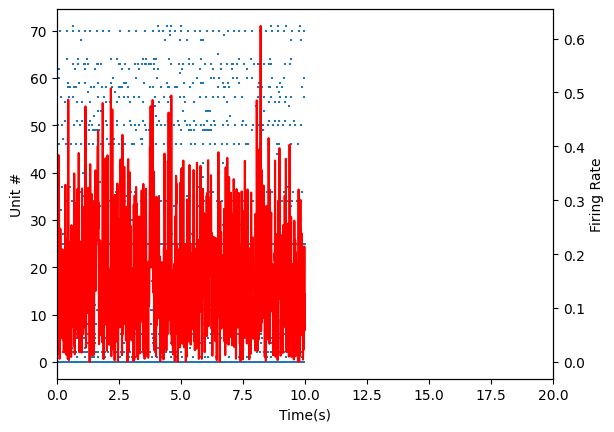

In [6]:
raster_analysis(sd_start)

In [7]:
n_data = sd_start.neuron_data

In [8]:
not_empties = []
arrays = sd_start.train

for i, arr in enumerate(arrays):
    if len(arr) > 0:
        not_empties.append(i)
        
print(not_empties)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 70, 71]


In [9]:
empties = []

for i, arr in enumerate(arrays):
    if len(arr) == 0:  # Check if the array is empty
        empties.append(i)  # Add the index to the "empties" list

In [10]:
sub_start = sd_start.subset(not_empties)

In [11]:
# Given a list of lists representing latencies, calculate the mean latency for each sublist.
# Returns a list containing the mean latencies for each sublist.
def latencies_mean(lat_list):
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

In [12]:
def calculate_mean_latencies(sd):
    num_neurons = sd.N
    latencies_array = [None] * num_neurons

    for curr_neuron in range(num_neurons):
        latencies = latencies_mean(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies

    return latencies_array

In [13]:
start_latencies = calculate_mean_latencies(sub_start)

In [14]:
def compute_in_out_degree(latencies_array):
    num_neurons = len(latencies_array)
    in_out_deg = [(0, 0) for _ in range(num_neurons)]

    for curr_neuron in range(num_neurons):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = latencies_array[curr_neuron]

        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1

        in_out_deg[curr_neuron] = (in_deg, out_deg)

    return in_out_deg

In [15]:
start_in_out_deg = compute_in_out_degree(start_latencies)

In [16]:
def label_nodes(in_out_deg, frac_threshold=0.2):
    node_info = ['b'] * len(in_out_deg)

    for i in range(len(in_out_deg)):
        test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
        test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])

        if test1 > frac_threshold:
            node_info[i] = 's'
        if test2 > frac_threshold:
            node_info[i] = 'r'

    return node_info

In [17]:
start_info = label_nodes(start_in_out_deg)

In [18]:
for index, element in enumerate(start_info):
    if element == 's' or element == 'r':
        print("Index:", index, "Element:", element)

Index: 7 Element: s
Index: 15 Element: s
Index: 18 Element: r
Index: 19 Element: s
Index: 20 Element: s
Index: 21 Element: r
Index: 27 Element: r
Index: 38 Element: r
Index: 42 Element: s
Index: 45 Element: s
Index: 56 Element: s
Index: 57 Element: r
Index: 59 Element: r


In [19]:
def update_node_info_colors(node_info):
    upd_node_info = []

    for i in range(len(node_info)):
        if node_info[i] == 'b':
            upd_node_info.append('grey')
        if node_info[i] == 's':
            upd_node_info.append('red')
        if node_info[i] == 'r':
            upd_node_info.append('blue')

    return upd_node_info

In [20]:
start_colors = update_node_info_colors(start_info)

In [21]:
print(start_colors)

['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'red', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'red', 'grey', 'grey', 'blue', 'red', 'red', 'blue', 'grey', 'grey', 'grey', 'grey', 'grey', 'blue', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'blue', 'grey', 'grey', 'grey', 'red', 'grey', 'grey', 'red', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'red', 'blue', 'grey', 'blue', 'grey', 'grey', 'grey', 'grey', 'grey']


In [22]:
start_colors[38] = 'black'
# start_colors[15] = 'black'

In [23]:
start_colors

['grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'red',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'red',
 'grey',
 'grey',
 'blue',
 'red',
 'red',
 'blue',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'blue',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'black',
 'grey',
 'grey',
 'grey',
 'red',
 'grey',
 'grey',
 'red',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'red',
 'blue',
 'grey',
 'blue',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey']

In [24]:
# To differentiate between different node degrees - 5, 20, 50.
def closest_value(number):
    closest = 5
    if abs(number - 20) < abs(number - closest):
        closest = 20
    if abs(number - 50) < abs(number - closest):
        closest = 50
    return closest

In [25]:
sub_start.neuron_data = sd_start.neuron_data

In [26]:
#sub_start.neuron_data[0].values()

In [27]:
sub_start.neuron_data[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71])

In [28]:
neur_data = sub_start.neuron_data[0]

In [29]:
keys_to_remove = [key for key in neur_data.keys() if key in empties]

In [30]:
keys_to_remove

[7, 10, 16, 43, 48, 66, 67]

In [31]:
for key in keys_to_remove:
    del neur_data[key]

In [32]:
sub_start.neuron_data[0] = neur_data

In [33]:
def sttc_neuron_plotter(inp_sd, upd_node_info, thresh):
    neuron_x = []
    neuron_y = []
    neuron_amp = []

    for neuron in inp_sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))

    neuron_amp = [closest_value(num) for num in neuron_amp]

    plt.figure(figsize=(8, 6))
    plt.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

    threshold = thresh
    sttc = inp_sd.spike_time_tilings()

    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j:
                continue
            if sttc[i, j] < threshold:
                continue
            if i in [7, 10, 16, 43, 48, 66, 67]:
                continue
            if j in [7, 10, 16, 43, 48, 66, 67]:
                continue
            ix, iy = inp_sd.neuron_data[0][i]['position']
            jx, jy = inp_sd.neuron_data[0][j]['position']
            print(i,j)
            linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
            opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
            plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("Before Light: Start of Experiment 8 (Dataset 5) - Tal Threshold ")  # Adding the title

    node_degree_legend_elements = [
        plt.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
        plt.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
    ]

    node_type_legend_elements = [
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]

    node_degree_legend = plt.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
    plt.gca().add_artist(node_degree_legend)

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
    plt.gca().add_artist(correlation_legend)

    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

    plt.show()

41 18
50 46


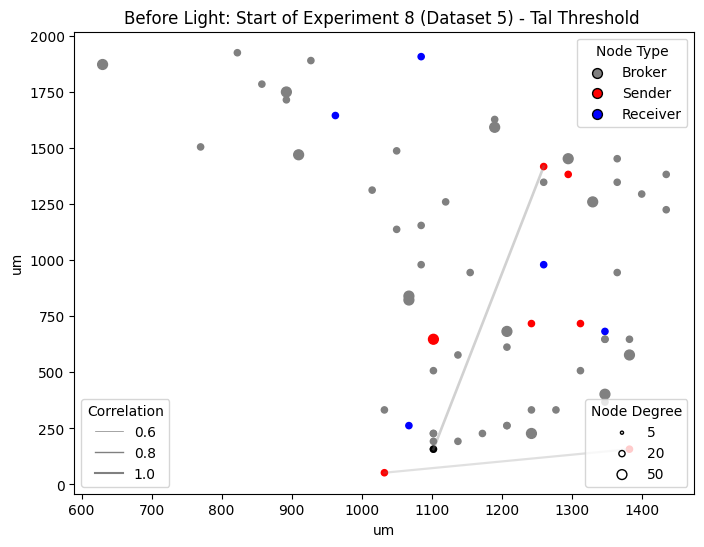

In [34]:
sttc_neuron_plotter(sub_start, start_colors, 0.8)

In [35]:
final_colors = ['grey'] * sub_start.N
final_colors[15] = 'red'
final_colors[38] = 'blue'

In [64]:
from matplotlib.patches import FancyArrow

def sttc_neuron_plotter(inp_sd, upd_node_info, thresh):
    neuron_x = []
    neuron_y = []
    neuron_amp = []

    for neuron in inp_sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    size = [15] * inp_sd.N
    size[15] = 120
    size[38] = 120
#         neuron_amp.append(np.mean(neuron['amplitudes']))

#     neuron_amp = [closest_value(num) for num in neuron_amp]

    plt.figure(figsize=(8, 6))
    plt.scatter(neuron_x, neuron_y, s=size, c=upd_node_info)

    threshold = thresh
    sttc = inp_sd.spike_time_tilings()

    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j:
                continue
            if sttc[i, j] < threshold:
                continue
            if i in [7, 10, 16, 43, 48, 66, 67]:
                continue
            if j in [7, 10, 16, 43, 48, 66, 67]:
                continue
            ix, iy = inp_sd.neuron_data[0][i]['position']
            jx, jy = inp_sd.neuron_data[0][j]['position']

            if i == 41 and j == 18:
                linewidth = 3.0  # Set a thicker linewidth
                arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=15,
                                   linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                plt.gca().add_patch(arrow)

            else:
                linewidth = 0.5  # Set a lower linewidth for other edges
                opacity = 0.3 + 0.1 * (sttc[i, j] - threshold)  # Adjust the opacity range according to your preference
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("Before Light: Start of Experiment 8 (Dataset 5) - Tal Threshold")

    node_degree_legend_elements = [
        plt.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
        plt.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
    ]

    node_type_legend_elements = [
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Neuron 41 (Sender)'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Neuron 18 (Receiver)'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Other')
    ]

#     node_degree_legend = plt.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
#     plt.gca().add_artist(node_degree_legend)

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

#     correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
#     plt.gca().add_artist(correlation_legend)

    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

    plt.show()

/tmp/ipykernel_780931/3897336371.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=15,


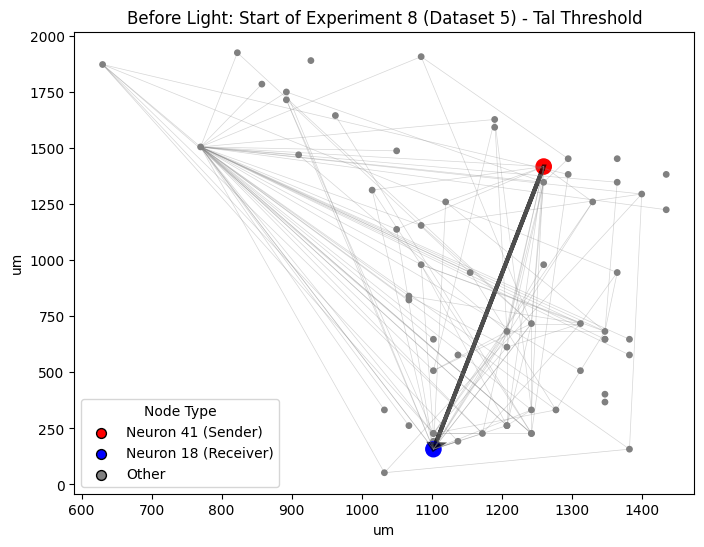

In [65]:
sttc_neuron_plotter(sub_start, final_colors, 0.3)

In [70]:
from matplotlib.patches import FancyArrow

def sttc_neuron_plotter(inp_sd, upd_node_info, thresh):
    neuron_x = []
    neuron_y = []
    neuron_amp = []

    for neuron in inp_sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    size = [15] * inp_sd.N
    size[15] = 120
    size[38] = 120

    plt.figure(figsize=(8, 6))
    plt.scatter(neuron_x, neuron_y, s=size, c=upd_node_info)

    threshold = thresh
    sttc = inp_sd.spike_time_tilings()

    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j:
                continue
            if sttc[i, j] < threshold:
                continue
            if i in [7, 10, 16, 43, 48, 66, 67]:
                continue
            if j in [7, 10, 16, 43, 48, 66, 67]:
                continue
            ix, iy = inp_sd.neuron_data[0][i]['position']
            jx, jy = inp_sd.neuron_data[0][j]['position']

            if i == 41 and j == 18:
                linewidth = 3.0  # Set a thicker linewidth
                arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=15,
                                   head_length=25, linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                plt.gca().add_patch(arrow)
            else:
                linewidth = 0.5  # Set a lower linewidth for other edges
                opacity = 0.3 + 0.1 * (sttc[i, j] - threshold)  # Adjust the opacity range according to your preference
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("c")

    node_degree_legend_elements = [
        plt.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
        plt.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
    ]

    node_type_legend_elements = [
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Neuron 41 (Sender)'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Neuron 18 (Receiver)'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Other')
    ]

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
    plt.savefig('/home/jovyan/work/Experiment/Thomas/Plot_C.png')
    plt.show()

/tmp/ipykernel_780931/4199346637.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=15,


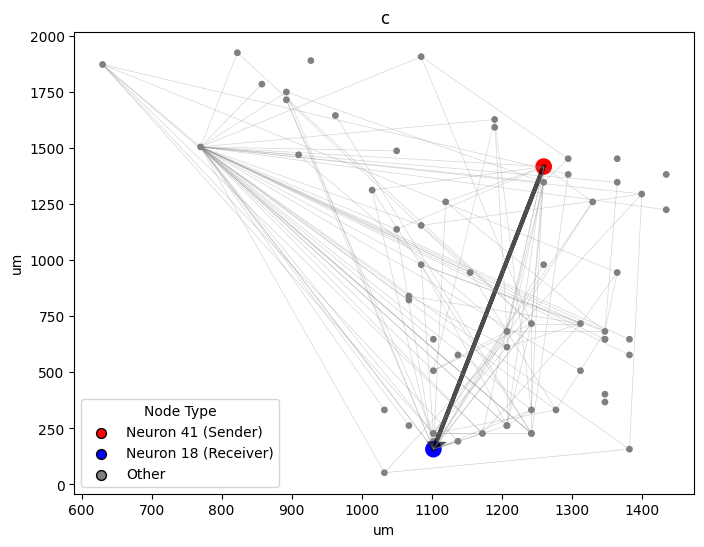

In [71]:
sttc_neuron_plotter(sub_start, final_colors, 0.3)